<a href="https://colab.research.google.com/github/RuslanMavlitov/IDE/blob/master/X_R_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> X-learner, R-learner. Принципы работы. Практика

Итак, давайте поработаем с X- и R- learner`ами c помощью библиотеки [CausalML](https://github.com/uber/causalml).

**Примечание:**

*В библиотеке scikit-uplift реализации X- и R- learner'ов отсутствуют.*



Для начала установим библиотеку (если вы не сделали этого ранее):

In [2]:
!git clone https://github.com/uber/causalml.git
!cd causalml
!pip install -r /content/causalml/requirements.txt
!pip install causalml

Cloning into 'causalml'...
remote: Enumerating objects: 3476, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 3476 (delta 206), reused 260 (delta 148), pack-reused 3128
Receiving objects: 100% (3476/3476), 61.85 MiB | 27.35 MiB/s, done.
Resolving deltas: 100% (2149/2149), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.9 MB/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.9/535.9 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for causalml: filename=causalml-0.13.0-cp310-cp310-linux_x86_64.whl size=1745467 sha256=1446e8334b62934171471a5aebdc63613c1b5b2320becdbe84f4ea779af0ff3d
  Stored in directory: /root/.cache/pip/wheels/52/7f/f2/8f4793418bc69b5106a3a3a54ea12df4fb6630a20d0b471a82
Successfully built causalml


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00


Импортируем необходимые библиотеки и загрузим семпл данных

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

# Импортируем X- и R-learner`ы (BaseXClassifier и BaseRClassifier) из библиотеки CausalML
# Нам нужны именно Classifier, так как мы будем решать задачу классификации
# Аналогичные реализации (Regressor) есть и для задач регрессии
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from catboost import CatBoostClassifier, CatBoostRegressor


# Прочитаем файл с данными
df = pd.read_csv("/content/data.csv")
df.head()

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target_class
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,2
3,9,675.83,1,0,Rural,1,Web,Discount,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,2


**Справка о признаках:**
* **recency** - количество месяцев с последней покупки клиента
* **history** - общая стоимость исторических покупок
* **used_discount** - указывает, пользовался ли клиент скидкой ранее
* **used_bogo** - указывает, пользовался ли клиент промоакцией ранее
* **zip_code** - класс почтового индекса:
    * Suburban - пригородный
    * Urban - городской
    * Rural - сельский
* **is_referral** - указывает, был ли клиент приобретен по реферальному каналу
* **channel** - каналы, которые использует клиент:
    * Phone - телефон
    * Web - интернет
    * Multichannel - многоканальный
* **treatment** - вид целевого воздействия:
    * **Discount** - было оказано целевое воздействие (предложена скидка)
    * **Buy One Get One** - было оказано целевое воздействие (предложена промоакция)
    * **No Offer** - целевого воздействие не было
* **target_class** - класс клиента (вспомогательный признак):
    * **0 - Control Non-Responders(CN)** 

        Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)
    * **1 - Control Responders(CR)**

        Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)
    * **2 - Treatment Non-Responders(CN)**

        Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
    * **3 - Treatment Responders(CN)** 
        
        Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

При построении классификатора нас интересует только факт того, совершил ли клиент покупку (класс 1) или нет (класс 0). Поэтому целевая переменная при классификации - конверсия. 

Посмотрим на распределение целевых влияний в данных:

* Discount - было оказано целевое влияние (предложена скидка)
* Buy One Get One - было оказано целевое влияние (предложена промоакция)
* No Offer - целевого влияния не было

In [2]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

## Предобработка данных

Подготовим данные:
* Преобразуем целевую переменную в признак конверсии, которую будем прогнозировать (купил/не купил)
* Создадим две отдельные таблицы:
    * В первой будем хранить информацию о пользователях, которым была предложена скидка (df_discount)
    * Во второй будем хранить информацию о пользователях, которым была предложена промоакция (df_bogo)
    
    В каждой из таблиц также сохраним данные о пользователях, на которых не было оказано целевое влияние (контрольная выборка).
* Также произведем кодировку категориальных признаков.

In [3]:
# Новый таргет - бинарная переменная (конверсия): 1 - купил, 0 - не купил
df['conversion'] = df['target_class'].map({0: 0, 1: 1, 2: 0, 3: 1})

# Разделим данные на две таблицы - данные по скидкам и промоакциям

# Выделим пользователей, на которых не было целевого воздействия, и тех, которым мы предлагали скидки
df_discount = df.copy().loc[
    (df['treatment'] == 'No Offer') |  (df['treatment'] == 'Discount')
].reset_index(drop=True)

# Выделим пользователей, на которых не было целевого воздействия, и тех, которым мы предлагали промоакции
df_bogo = df.copy().loc[
    (df['treatment'] == 'No Offer') | (df['treatment'] == 'Buy One Get One')
].reset_index(drop=True)

# Перекодируем столбец с влиянием: 1 - было влияние, 0 - не было
df_discount['treatment'] = df_discount['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)
df_bogo['treatment'] = df_bogo['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)

# Закодируем оставшиеся категориальные признаки
df_discount = pd.get_dummies(df_discount)
df_bogo = pd.get_dummies(df_bogo)

# Выведем размерности полученных таблиц:
print(df_discount.shape)
print(df_bogo.shape)

(42613, 14)
(42693, 14)


Посмотрим на результаты:

In [4]:
df_discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1
1,9,675.83,1,0,1,1,2,0,1,0,0,0,0,1
2,9,675.07,1,1,1,1,2,0,1,0,0,0,1,0
3,2,101.64,0,1,0,1,3,1,0,0,1,0,0,1
4,4,241.42,0,1,1,0,0,0,1,0,0,1,0,0


In [5]:
df_bogo.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,2,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,2,0,0,1,0,0,0,1
3,2,45.34,1,0,0,1,2,0,0,0,1,0,0,1
4,6,134.83,0,1,0,1,3,1,0,1,0,0,1,0


In [6]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']

target_col = 'conversion'
treatment_col = 'treatment'

## Работаем с данными о скидках

### Обучающая и тестовая выборка

Мы будем работать с данными о скидках. Оценить uplift-эффект на данных о результатх промоакций вам предстоит самостоятельно.

Разделим данные на тренировочную и тестовую выборки.

In [7]:
df_discount_train, df_discount_test = train_test_split(
    df_discount, 
    stratify=df_discount[[treatment_col, target_col]], 
    random_state=13, 
    test_size=0.3
)
print(df_discount_train.shape)
print(df_discount_test.shape)

df_discount_train.head()

(29829, 14)
(12784, 14)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
28236,1,616.27,1,0,1,1,2,0,0,0,1,1,0,0
37748,11,158.76,0,1,1,0,0,0,0,0,1,0,0,1
41505,3,269.60,1,0,1,1,2,0,0,0,1,0,1,0
1595,3,458.76,1,0,0,1,2,0,1,0,0,1,0,0
31544,7,209.56,0,1,0,1,2,0,0,0,1,1,0,0


### Quni-curve и qini-score

Создаем функцию для построения qini-curve и расчета qini-score

In [8]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

## Uplift-моделирование с помощью CausalML

Давайте посмотрим на реализацию S-learner и T-learner из библиотеки [CausalML](https://github.com/uber/causalml) от компании Uber ([документация](https://causalml.readthedocs.io/en/latest/index.html)).

**Примечание:**

Результаты uplift-моделирования могут несколько отличаться в зависимости от версии библиотек. Будьте внимательны.

### X-learner (CausalML)

Попробуем воспользоваться X-learner`ом.

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

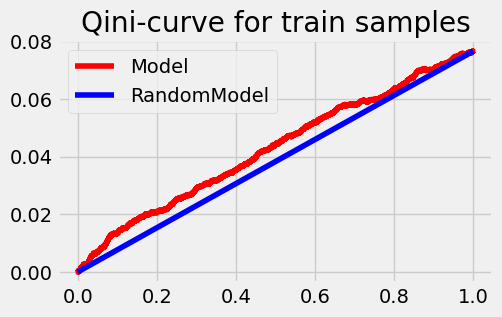

Qini score: 129.915


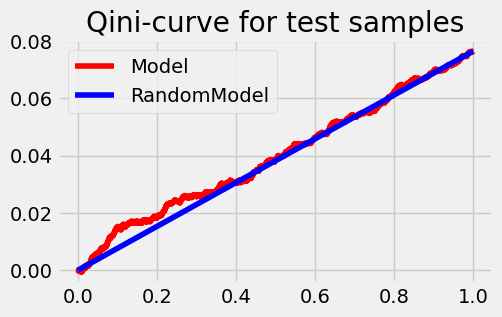

Qini score: 19.396


In [9]:
# Давайте по данным построим X-learner

# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=13, verbose=0),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(
    X=df_discount_train[feature_cols],
    treatment=df_discount_train[treatment_col],
    y=df_discount_train[target_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_discount_train[feature_cols].values.copy()))
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_discount_test[feature_cols].values.copy()))
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Не будем реализовывать X-learner руками, хотя задача не такая тяжелая. Вы можете посмотреть реализацию в исходном коде [СausalML на github]((https://github.com/uber/causalml)). Можно поуправлять параметрами представленных моделей, взять более тяжелые модели или расширить обучающую выборку, чтобы повысить результаты. Но помните, что усложенение используемых моделей приведет к значительному увеличению времени обучения.

### R-learner (CausalML)

Теперь давайте посмотрим на R-learner.

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

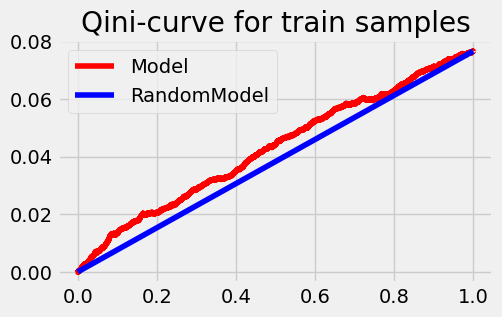

Qini score: 131.817


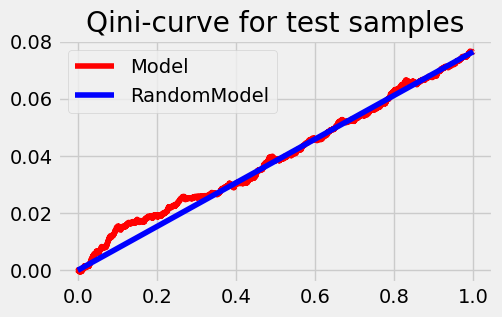

Qini score: 15.069


In [10]:
# Давайте по данным построим R-learner

# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=13, verbose=0),
    effect_learner=LinearRegression(),
    random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(X=df_discount_train[feature_cols],
              treatment=df_discount_train[treatment_col],
              y=df_discount_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_discount_train[feature_cols].values.copy()))
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_discount_test[feature_cols].values.copy()))
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Итак, что мы видим? на текущей задаче X- и R- Learner`ы при заданных моделях и их параметрах показатели себя не очень хорошо. Но мы использовали только базовые модели, вы можете использовать более сложные предикторы на каждом этапе и подобрать их параметры. Мы уверены в том, что этим навыком вы уже владеете и сможете сделать это самостоятельно!

## Работаем с данными о промоакциях 

Теперь вам предстоит самостоятельно провести uplift-моделирование с помощью X- и R- Learner`ов на данных о промоакциях. 

### Обучающая и тестовая выборки

Разделим данные на тренировочную и тестовую выборки.

In [11]:
df_bogo_train, df_bogo_test = train_test_split(
    df_bogo, 
    stratify=df_bogo[[treatment_col, target_col]], 
    random_state=13, 
    test_size=0.3
)
print(df_bogo_train.shape)
print(df_bogo_test.shape)

df_bogo_train.head()

(29885, 14)
(12808, 14)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
20518,2,167.94,1,0,1,1,2,0,0,1,0,0,0,1
34388,11,129.29,1,0,0,1,2,0,0,1,0,0,1,0
40663,9,129.61,0,1,1,0,0,0,1,0,0,0,0,1
30626,2,333.87,1,0,1,1,2,0,0,1,0,1,0,0
16372,4,103.79,1,0,1,1,2,0,0,0,1,0,0,1


### X-learner (CausalML)

**Задание №1**

Давайте проведем uplift-моделирование на датасете с промо-акциями (df_bogo) с помощью X-learner из библиотеки `CausalML` (BaseXClassifier).

В качестве `outcome_learner` используйте модель логистической регрессии (`LogisticRegression`) из библиотеки scikit-learn с параметрами по умолчанию. Параметр random_state установите в значение 13. 

В качестве `effect_learner` возьмите модель линейной регрессии (`LinearRegression`) из библиотеки scikit-learn с параметрами по умолчанию. 

Рассчитайте qini-score на тестовой выборке для полученного X-learner. Запишите полученный результат с точностью до 3-его знака после запятой. 

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

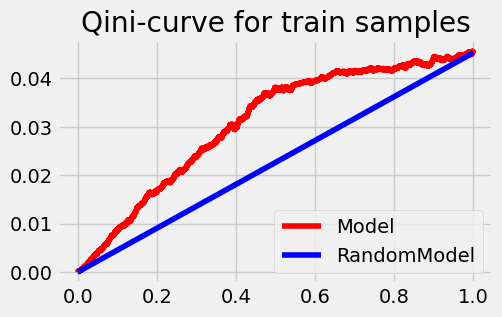

Qini score: 241.528


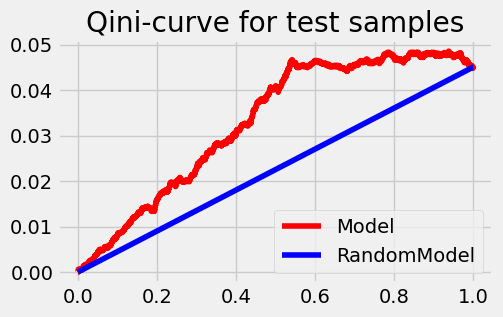

Qini score: 133.209


In [12]:
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=13),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(
    X=df_bogo_train[feature_cols],
    treatment=df_bogo_train[treatment_col],
    y=df_bogo_train[target_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_bogo_train[feature_cols].values.copy()))
df_bogo_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_bogo_test[feature_cols].values.copy()))
df_bogo_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_bogo_train, title='train')
qini_df(df_bogo_test, title='test')

### R-learner (CausalML)

**Задание №2**

Давайте проведем uplift-моделирование на датасете с промо-акциями (df_bogo) с помощью R-learner из библиотеки `CausalML` (BaseRClassifier).

В качестве `outcome_learner` используйте модель логистической регрессии (`LogisticRegression`) из библиотеки scikit-learn с параметрами по умолчанию. Параметр `random_seed` установите в значение 13. 

В качестве `effect_learner` возьмите модель линейной регрессии (`LinearRegression`) из библиотеки scikit-learn с параметрами по умолчанию. 

Параметр `random_state` для BaseRClassifier установите в значение 42. 

Рассчитайте qini-score на тестовой выборке для полученного R-learner. Запишите полученный результат с точностью до 3-его знака после запятой. 

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

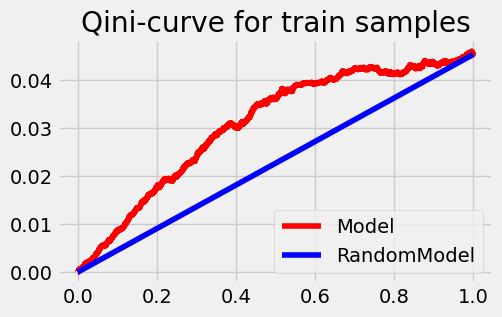

Qini score: 241.092


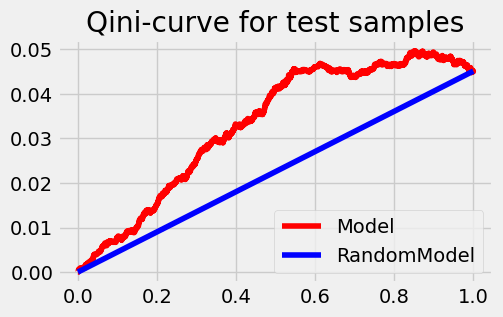

Qini score: 134.928


In [13]:
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(random_state=13),
    effect_learner=LinearRegression(),
    random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(X=df_bogo_train[feature_cols],
              treatment=df_bogo_train[treatment_col],
              y=df_bogo_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_bogo_train[feature_cols].values.copy()))
df_bogo_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_bogo_test[feature_cols].values.copy()))
df_bogo_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_bogo_train, title='train')
qini_df(df_bogo_test, title='test')